## Plot sleep of animals after 6X training protocols or no training protocol. No SD

In [352]:
library(scopr)
library(ggplot2)
library(data.table)
library(ggprism)
library(ggetho)

theme_set(ggprism::theme_prism(base_size=25))
parse_interval <- function(intervals, idx) {
    
    x <-  sapply(intervals, function(interval) {
        interval_zt <- unlist(strsplit(interval, split="-"))[[idx]]
        out <- as.numeric(gsub(x=interval_zt, pattern="ZT", replacement=""))
        return(out)
    })
    return(x)
}

In [354]:
metadata <- data.table::fread("metadata.csv")


In [359]:
metadata <- metadata[experiment%in% c("24hr LTM", "24hr LTM GTACR"),]
metadata <- metadata[!is.na(date),]
metadata <- metadata[Genotype=="Iso31",]
metadata <- metadata[interactor%in% c("NONE", "DefaultStimulator"),]

metadata[, .N, by=.(interactor, experiment, Training)]

interactor,experiment,Training,N
<chr>,<chr>,<fct>,<int>
DefaultStimulator,24hr LTM,6X_Spaced,76
DefaultStimulator,24hr LTM,6X_Massed,50


In [360]:
metadata$Training <- factor(metadata$Training, levels=c("No_training", "6X_Massed", "6X_Spaced"))
metadata[is.na(ROI), ROI := "NONE"]

metadata_etho <- data.table::fread("metadata_etho.csv")

In [361]:
metadata[, .(Files, interactor_time_window)]

Files,interactor_time_window
<chr>,<chr>
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator
2023-07-12_14-25-09(ET_spaced_overnight),No_stimulator


In [362]:
metadata <- rbind(
    metadata_etho[, .(Files, ROI="NONE", region_id, machine_name, date, reference_hour, Training, experiment, Genotype, interactor, interactor_time_window, User)],
    metadata[, .(Files, ROI, region_id, machine_name, date, reference_hour, Training, experiment, Genotype, interactor, interactor_time_window, User)]
)

In [365]:
metadata[, .N, by=.(interactor, experiment, Training)]

interactor,experiment,Training,N
<chr>,<chr>,<fct>,<int>
DefaultStimulator,24hr LTM,No_training,31
DefaultStimulator,24hr LTM,6X_Spaced,76
DefaultStimulator,24hr LTM,6X_Massed,50


In [367]:
metadata[, interval1:="NONE"]
metadata[, interval2:="NONE"]
metadata[interactor_time_window!="No_stimulator", interval1 := parse_interval(interactor_time_window, 1)]           
metadata[interactor_time_window!="No_stimulator", interval2 := parse_interval(interactor_time_window, 2)]
metadata$date <- as.character(metadata$date)


In [369]:
metadata[, .(.N), by=.(Training, experiment, machine_name, date)]

Training,experiment,machine_name,date,N
<fct>,<chr>,<chr>,<chr>,<int>
No_training,24hr LTM,ETHOSCOPE_036,2023-07-12,9
No_training,24hr LTM,ETHOSCOPE_036,2023-07-13,7
No_training,24hr LTM,ETHOSCOPE_042,2023-07-18,9
No_training,24hr LTM,ETHOSCOPE_036,2023-07-31,6
6X_Spaced,24hr LTM,ETHOSCOPE_036,2023-07-12,10
6X_Spaced,24hr LTM,ETHOSCOPE_036,2023-07-13,9
6X_Spaced,24hr LTM,ETHOSCOPE_042,2023-07-18,9
6X_Massed,24hr LTM,ETHOSCOPE_036,2023-07-23,20
6X_Massed,24hr LTM,ETHOSCOPE_036,2023-07-24,20


In [370]:
metadata[is.na(Training),]

Files,ROI,region_id,machine_name,date,reference_hour,Training,experiment,Genotype,interactor,interactor_time_window,User,interval1,interval2
<chr>,<chr>,<int>,<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [375]:
metadata_linked <- scopr::link_ethoscope_metadata(metadata, result_dir="/ethoscope_data/results")

searching the provided database for data matching query

parsing date and time

processing rows without time

... removing duplicates i.e. no 2 db files will be from same ethoscope and day.
  If more than 1 is found, we keep the last. A warning will be emitted in that case

processing rows with time

copying query

creating path and experiment_id columns



In [376]:
metadata_linked[is.na(Training),]

id,file_info,machine_name,machine_id,datetime,Files,ROI,region_id,reference_hour,Training,experiment,Genotype,interactor,interactor_time_window,User,interval1,interval2
<fct>,<list>,<chr>,<chr>,<dttm>,<chr>,<chr>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [377]:
dt <- scopr::load_ethoscope(
    metadata_linked,
    verbose=FALSE,
    reference_hour=NA,
    cache="/ethoscope_data/cache",
    FUN=sleepr::sleep_annotation, velocity_correction_coef=0.0048, time_window_length=10, min_time_immobile=300
)



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048



Time window length: 10

Min time immobile: 300

Velocity correction coefficient: 0.0048


In [381]:
dt_bin <- behavr::bin_apply_all(dt, y="asleep", x_bin_length=behavr::mins(30), summary_FUN=mean)
dt_bin$asleep <- dt_bin$asleep*30
metadata_linked<-dt_bin[,meta=TRUE]


In [387]:
metadata_linked <- merge(
    metadata_linked[, .(id, machine_name, date=as.character(substr(datetime, 1, 10)), region_id)],
    metadata,
    by=c("machine_name", "date", "region_id"), all=TRUE
)

In [388]:
metadata_linked[is.na(Training),]

machine_name,date,region_id,id,Files,ROI,reference_hour,Training,experiment,Genotype,interactor,interactor_time_window,User,interval1,interval2
<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [389]:
nrow(metadata_linked)

[1] 157

In [390]:
setkey(metadata_linked, id)
setmeta(dt_bin, metadata_linked)

In [391]:
metadata_linked[is.na(Training),]

machine_name,date,region_id,id,Files,ROI,reference_hour,Training,experiment,Genotype,interactor,interactor_time_window,User,interval1,interval2
<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [392]:
saveRDS(object = dt_bin, file = "dt_bin.RDS")

Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”


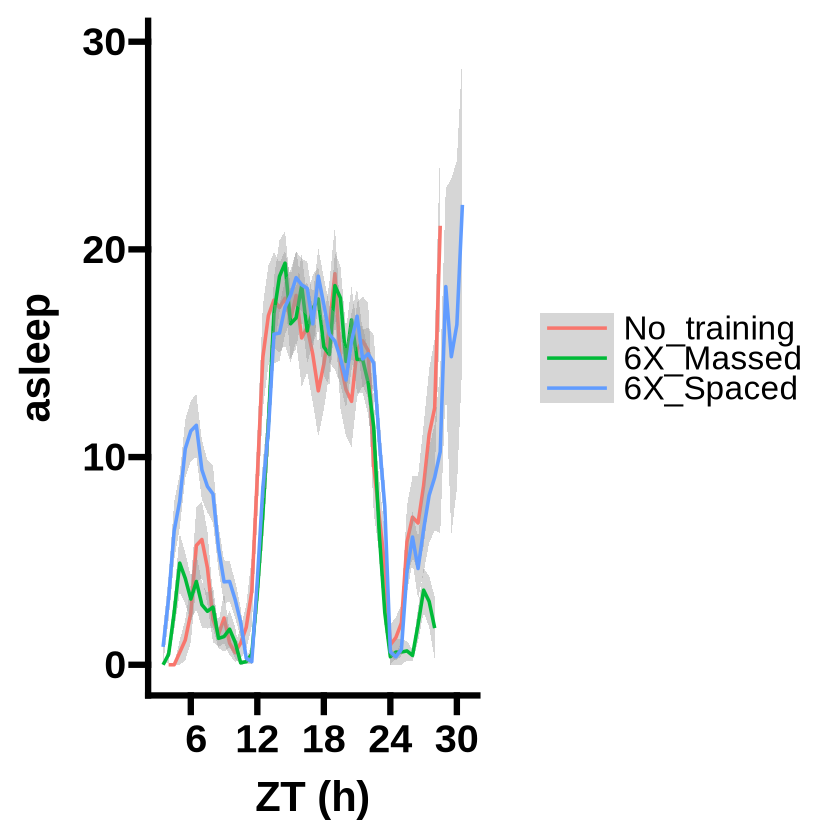

In [393]:
ggplot(data=behavr::rejoin(dt_bin)[Genotype=="Iso31" & interactor=="DefaultStimulator",], aes(x=t, y=asleep, color=Training)) +
    stat_pop_etho() +
    scale_x_hours(name="ZT")


In [ ]:
metadata_linked$ROI